# Прогнозирование оттока клиентов телеком компании

**Цель проекта:**  

Разработка модели модели машинного обучения для оператора связи «Ниединогоразрыва.ком», позволяющей прогнозировать отток клиентов.  
Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.  
Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Эффективность работы модели будет оцениваться метрикой ROC-AUC.  
Модель должна показать на тестовой выборке уровень метрики ROC-AUC не менее 0.85

**Описание услуг оператора**  

Оператор предоставляет два основных типа услуг:
1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание предоставленных данных**

Данные состоят из файлов, полученных из разных источников:
- contract_new.csv — информация о договоре
- personal_new.csv — персональные данные клиента
- internet_new.csv — информация об интернет-услугах
- phone_new.csv — информация об услугах телефонии

Во всех файлах столбец customerID содержит код клиента.  
Информация о договорах актуальна на 1 февраля 2020.

**План выполнения проекта:**

1. Загрузка библиотек и загрузка данных с первичным обзором
2. Предобработка данных
  - заполнение пропусков
  - коррекция типов данных
  - выявление и обработка аномалий
3. Объединение датафреймов
4. Исследование единого датафрейма
  - заполнение пропусков
  - создание новых признаков (при необходимости)
  - создание целевого признака
  - проверка признаков на мультиколлинеарность с использованием phik
5. Разделение данных на учебную и тестовую выборки в пропорции 3:1
6. Кодирование и масштабирование признаков
7. Постройка и обучение на тестовой выборке с подбором гиперпараметров с кросс-валидацией нескольких моделей
  - LogisticRegression
  - RandomForestClassifier
  - CatBoostClassifier
8. Выбор лучшей модели на основе метрики ROC-AUC
9. Исследование лучшей модели
  - проверка качества лучшей модели на тестовой выборке
  - проверка на адекватность
  - построение матрицы ошибок
  - исследование важности признаков лучшей модели.
10. Общий вывод

In [4]:
#pip install ydata-profiling
#pip install phik
!pip install bytewax==0.16.2 ydata-profiling
!pip install catboost

In [103]:
!pip install torch
!pip install torchvision
!pip install psycopg2

In [159]:
import pandas as pd
import datetime
import time
import numpy as np
#from ydata_profiling import ProfileReport
import phik
from phik import resources, report
from phik import phik_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# для графического отображения результатов
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from catboost import CatBoostClassifier

from lightgbm import LGBMClassifier

RANDOM_STATE = 110923

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import average_precision_score

### Загрузка библиотек и данных

In [160]:
# загрузка датафреймов (try - локально, except - по ссылке)
try:
    df_contract = pd.read_csv('datasets/contract_new.csv')
    df_personal = pd.read_csv('datasets/personal_new.csv')
    df_internet = pd.read_csv('datasets/internet_new.csv')
    df_phone = pd.read_csv('datasets/phone_new.csv')

except:
    df_contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
    df_personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
    df_internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
    df_phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')

In [161]:
df_contract.sample(40)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
5594,0027-KWYKW,2018-03-01,No,Month-to-month,Yes,Electronic check,83.75,2080.35
5893,3549-ZTMNH,2019-02-01,No,Two year,Yes,Bank transfer (automatic),24.00,290.88
521,4109-CYRBD,2017-09-01,No,Month-to-month,Yes,Electronic check,51.60,1586.18
2817,0936-NQLJU,2016-09-01,No,Two year,No,Credit card (automatic),20.65,914.38
6158,3845-FXCYS,2019-12-01,No,Month-to-month,Yes,Electronic check,19.65,39.69
1589,7351-KYHQH,2019-07-01,No,Month-to-month,Yes,Electronic check,64.95,472.84
4334,3969-GYXEL,2019-03-01,No,Month-to-month,No,Electronic check,76.40,874.02
4721,4211-MMAZN,2019-12-01,No,Month-to-month,No,Mailed check,20.25,43.34
6723,2068-WWXQZ,2016-04-01,No,Two year,No,Bank transfer (automatic),20.05,922.3
960,2826-DXLQO,2019-07-01,No,Month-to-month,No,Bank transfer (automatic),29.80,208.6


In [162]:
#report = ProfileReport(df_contract)
#report.to_file('data_report_contract_new.html')
#report.to_notebook_iframe()

In [163]:
df_personal

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [164]:
#report = ProfileReport(df_personal)
#report.to_file('data_report_personal_new.html')
#report.to_notebook_iframe()

In [165]:
df_internet

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [166]:
#report = ProfileReport(df_internet)
#report.to_file('data_report_internet_new.html')
#report.to_notebook_iframe()

In [167]:
df_phone

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


In [168]:
#report = ProfileReport(df_phone)
#report.to_file('data_report_phone_new.html')
#report.to_notebook_iframe()

**Вывод**

- У датафреймов разное количество строк (7043, 5517 и 6361)
- Названия признаков в виде слитных слов, разделенных прописной буквой (например, customerID). Нужно привести в змеиный вид (в виде customer_id)
- Пропусков нет
- Дубликатов нет
- Данные имеют как категориальное значение (например, PaperlessBilling, PaymentMethod), так и числовые значения (например признак MonthlyCharges, 29.85)
- Признак TotalCharges имеет тип данных object, однако, глядя на первые строки таблицы в этой колонке значения похожи на значения в колонке MonthlyCharges. Нужно выяснить в чем причина и привести данные к нужному формату. Данную рпоцедуру проведем в разделе 1.3 Подготовка данных для машинного обучения

### Объединение датафреймов

In [169]:
df_merged=pd.merge(df_contract,df_personal, how='outer')
df_merged=pd.merge(df_merged,df_phone, how='outer')
df_merged=pd.merge(df_merged,df_internet, how='outer')

# контроль результата

print(df_merged.shape)
print(df_merged.info())
display(df_merged.head())

(7043, 20)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  MultipleLines     6361 non-null   object 
 13  InternetService   5517 non-null   object 
 14  OnlineSecurity    5517 non-null   object 
 15  OnlineBackup      5517 non-null   object 
 16  DeviceProtection  5517 non-null

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No


### Предобработка данных

In [170]:
# Подсчет пропусков в каждом столбце
missing_values = df_merged.isnull().sum()

# Вывод результатов
print(missing_values)

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
dtype: int64


In [171]:
df_merged = df_merged.fillna(value='Not_using')

In [172]:
# Подсчет пропусков в каждом столбце
missing_values = df_merged.isnull().sum()

# Вывод результатов
print(missing_values)

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64


Переименуем столбцы змеиным стилем

In [173]:
# Создание словаря с новыми именами столбцов
new_column_names = {
    'customerID': 'customer_id',
    'BeginDate': 'begin_date',
    'EndDate': 'end_date',
    'Type': 'type',
    'PaperlessBilling': 'paperless_billing',
    'PaymentMethod': 'payment_method',
    'MonthlyCharges': 'monthly_charges',
    'TotalCharges': 'total_charges',
    'SeniorCitizen': 'senior_citizen',
    'Partner': 'partner',
    'Dependents': 'dependents',
    'MultipleLines': 'multiple_lines',
    'InternetService': 'internet_service',
    'OnlineSecurity': 'online_security',
    'OnlineBackup': 'online_backup',
    'DeviceProtection': 'device_protection',
    'TechSupport': 'tech_support',
    'StreamingTV': 'streaming_tv',
    'StreamingMovies': 'streaming_movies',
}

# Переименование столбцов с помощью метода rename()
df_merged.rename(columns=new_column_names, inplace=True)

# Вывод обновленного датафрейма с переименованными столбцами
print(df_merged)

     customer_id  begin_date end_date            type paperless_billing  \
0     7590-VHVEG  2020-01-01       No  Month-to-month               Yes   
1     5575-GNVDE  2017-04-01       No        One year                No   
2     3668-QPYBK  2019-10-01       No  Month-to-month               Yes   
3     7795-CFOCW  2016-05-01       No        One year                No   
4     9237-HQITU  2019-09-01       No  Month-to-month               Yes   
...          ...         ...      ...             ...               ...   
7038  6840-RESVB  2018-02-01       No        One year               Yes   
7039  2234-XADUH  2014-02-01       No        One year               Yes   
7040  4801-JZAZL  2019-03-01       No  Month-to-month               Yes   
7041  8361-LTMKD  2019-07-01       No  Month-to-month               Yes   
7042  3186-AJIEK  2014-08-01       No        Two year               Yes   

                 payment_method  monthly_charges total_charges  gender  \
0              Electronic

#### Создание целевого прзнака

Исходим из того, что если в дате окончаниия контракта стоит 'No', то клиент остался с оператором, а если присутствует конкретная дата, то ушёл.


In [174]:
# Создание нового признака на основе значения в столбце EndDate
df_merged['target_feature'] = df_merged['end_date'].apply(lambda x: 'No' if x == 'No' else 'Yes')

df_merged['target_feature'].replace({'No': 0, 'Yes': 1}, inplace=True)

# Вывод обновленного датафрейма
display(df_merged.sample(20))

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,target_feature
4745,6116-RFVHN,2017-04-01,2019-05-01,Month-to-month,Yes,Electronic check,100.45,2511.25,Female,0,...,No,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,1
2410,3503-TYDAY,2016-07-01,No,Month-to-month,No,Electronic check,80.45,3597.72,Female,0,...,No,Yes,Fiber optic,No,Yes,No,No,No,No,0
323,7102-JJVTX,2019-05-01,No,One year,No,Mailed check,48.60,472.39,Female,0,...,Yes,No,DSL,Yes,No,No,No,No,No,0
1914,5356-CSVSQ,2019-11-01,No,Month-to-month,No,Electronic check,64.60,207.37,Female,0,...,No,Yes,DSL,No,No,No,Yes,Yes,No,0
5959,2729-VNVAP,2017-05-01,No,Two year,No,Credit card (automatic),19.80,699.14,Female,0,...,Yes,No,Not_using,Not_using,Not_using,Not_using,Not_using,Not_using,Not_using,0
6452,9529-OFXHY,2018-11-01,No,Month-to-month,Yes,Bank transfer (automatic),87.75,1316.25,Male,0,...,No,Yes,Fiber optic,Yes,No,No,No,Yes,No,0
736,6647-ZEDXT,2017-08-01,No,One year,No,Credit card (automatic),110.45,3313.5,Female,0,...,No,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,0
4789,0511-JTEOY,2019-11-01,No,Month-to-month,No,Mailed check,71.10,213.3,Female,0,...,No,No,Fiber optic,No,No,No,No,No,No,0
6903,9609-BENEA,2017-03-01,No,One year,Yes,Electronic check,69.00,2511.6,Male,0,...,No,Yes,DSL,No,Yes,No,Yes,Yes,No,0
3707,9537-JALFH,2014-05-01,No,Two year,No,Bank transfer (automatic),19.90,1373.1,Male,0,...,Yes,No,Not_using,Not_using,Not_using,Not_using,Not_using,Not_using,Not_using,0


Приведем все столбцы к нижнему регистру

In [175]:
#df_merged.columns = df_merged.columns.str.lower()

Столбец 'TotalCharges' имеет неправильный тип 'object' вместо 'float64' и это нужно исправить перед анализом

In [176]:
#приведение данных в столбце 'TotalCharges' к типу 'float64'

df_merged['total_charges'] = pd.to_numeric(df_merged['total_charges'],errors='coerce')

#проверка результата

print(df_merged.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7032 non-null   float64
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  multiple_lines     7043 non-null   object 
 13  internet_service   7043 non-null   object 
 14  online_security    7043 non-null   object 
 15  online_backup      7043 non-null   object 
 16  device_protection  7043 

Создадим признак duration для отоброжения сколько дней клиент пользуется услугами компании

Заменим значения 'No' в столбце 'end_date' в датафрейме на значение '2020-02-01', так как эта дата соответствует дате выгрузки данных.

In [177]:
df_merged['end_date'] = df_merged['end_date'].replace('No', '2020-02-01')

In [178]:
# Преобразуем столбцы в формат даты

df_merged['begin_date'] = pd.to_datetime(df_merged['begin_date'])
df_merged['end_date'] = pd.to_datetime(df_merged['end_date'])

# Создаем новый столбец с длительностью контракта в днях

df_merged['contract_days'] = (df_merged['end_date'] - df_merged['begin_date']).dt.days

print("Значения нового признака:",sorted(df_merged['contract_days'].unique()))
display(df_merged.head())

Значения нового признака: [0, 28, 30, 31, 59, 61, 62, 90, 91, 92, 121, 122, 123, 151, 153, 181, 182, 183, 184, 212, 213, 214, 215, 242, 243, 244, 245, 273, 274, 275, 276, 303, 304, 305, 306, 334, 335, 336, 337, 365, 366, 393, 395, 396, 397, 424, 425, 426, 427, 454, 456, 457, 458, 485, 486, 487, 488, 489, 515, 516, 517, 518, 519, 546, 547, 548, 549, 550, 577, 578, 579, 580, 607, 608, 609, 610, 611, 638, 639, 640, 641, 668, 669, 670, 671, 672, 699, 700, 701, 702, 703, 730, 731, 759, 760, 761, 762, 789, 790, 791, 792, 793, 820, 821, 822, 823, 850, 851, 852, 853, 854, 881, 882, 883, 884, 911, 912, 913, 914, 915, 942, 943, 944, 945, 946, 972, 973, 974, 975, 976, 1003, 1004, 1005, 1006, 1007, 1034, 1035, 1036, 1037, 1064, 1065, 1066, 1067, 1068, 1095, 1096, 1124, 1125, 1126, 1127, 1155, 1156, 1157, 1158, 1185, 1186, 1187, 1188, 1216, 1217, 1218, 1219, 1246, 1247, 1248, 1249, 1277, 1278, 1279, 1280, 1308, 1309, 1310, 1311, 1338, 1339, 1340, 1341, 1369, 1370, 1371, 1372, 1399, 1400, 1401, 1402

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,target_feature,contract_days
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,Not_using,DSL,No,Yes,No,No,No,No,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,Not_using,DSL,Yes,No,Yes,Yes,No,No,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,No,Fiber optic,No,No,No,No,No,No,0,153


Проверим пропуски

In [179]:
missing_values = df_merged.isnull().sum()

# Вывод количества пропущенных значений в каждом столбце
print(missing_values)

customer_id           0
begin_date            0
end_date              0
type                  0
paperless_billing     0
payment_method        0
monthly_charges       0
total_charges        11
gender                0
senior_citizen        0
partner               0
dependents            0
multiple_lines        0
internet_service      0
online_security       0
online_backup         0
device_protection     0
tech_support          0
streaming_tv          0
streaming_movies      0
target_feature        0
contract_days         0
dtype: int64


Посмотрим на строки с пропусками в признаке total_charges

In [198]:
# Вывод строк с пропусками в признаке total_charges
df_merged[df_merged['total_charges'].isnull()]

,type,paperless_billing,payment_method,monthly_charges,total_charges,senior_citizen,partner,dependents,multiple_lines,internet_service,target_feature,contract_days


Во всех строках признака total_charges одна и та же дата - 01.02.2020г. и она совпадает с датой выгрузки датафреймов. Очевидно, что клиенты только заключили договор и они еще не оплачивали услуги связи. Такие пропуски заменим нулями

In [181]:
df_merged['total_charges'] = df_merged['total_charges'].fillna(0)

Проверим результат после заполнения всех пропусков

In [182]:
df_merged.isnull().sum().sort_values(ascending=False)

customer_id          0
begin_date           0
target_feature       0
streaming_movies     0
streaming_tv         0
tech_support         0
device_protection    0
online_backup        0
online_security      0
internet_service     0
multiple_lines       0
dependents           0
partner              0
senior_citizen       0
gender               0
total_charges        0
monthly_charges      0
payment_method       0
paperless_billing    0
type                 0
end_date             0
contract_days        0
dtype: int64

Удаление лишних признаков

Признаки на удаление:

- gender — пол клиента удалим, так как пользователей 50/50 мужчин/женщин
- begin_date и end_date — дата заключения / расторжения договора не окажет влияние на обучение моделей ML

In [183]:
# удаление признаков
df_merged = df_merged.drop(['customer_id', 'gender', 'begin_date', 'end_date'], axis = 1)

### Исследание признаков на мультиколлинеарность методом phik

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'senior_citizen', 'target_feature', 'contract_days']


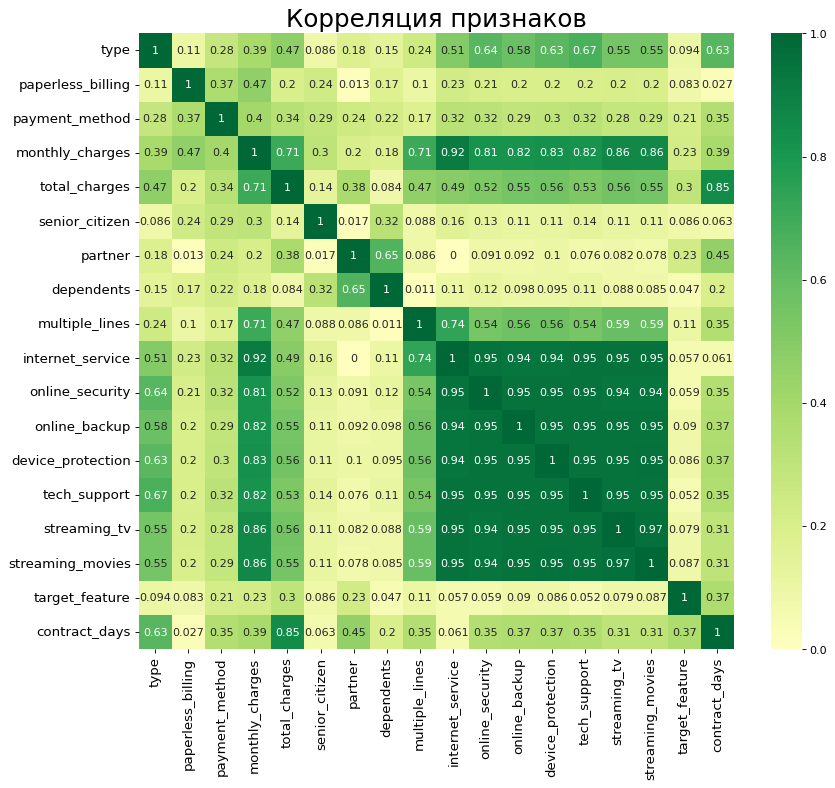

In [184]:
corr_matrix = phik_matrix(df_merged)

# вывод матрицы в виде Heatmap

plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(corr_matrix, xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns, cmap='RdYlGn', center=0, annot=True)

plt.title('Корреляция признаков', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Вывод:
есть ряд признаков, очень сильно(с коэффициентом более 0.94) коррелирующих межу собой:
'InternetSerivice','OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'.
Все эти признаки отражают пользование услугами, основанными на доступе к Интернет, следовательно их все можно удалить, оставив лишь признак 'InternetSerivice'.
Кроме того нужно удалить признак 'customerID' как бесполезный, равно как и 'gender'.

In [185]:
# удаление сильно кореллироющих между собой признаков

df_merged = df_merged.drop('online_security', axis=1)
df_merged = df_merged.drop('online_backup', axis=1)
df_merged = df_merged.drop('device_protection', axis=1)
df_merged = df_merged.drop('tech_support', axis=1)
df_merged = df_merged.drop('streaming_tv', axis=1)
df_merged = df_merged.drop('streaming_movies', axis=1)

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'senior_citizen', 'target_feature', 'contract_days']


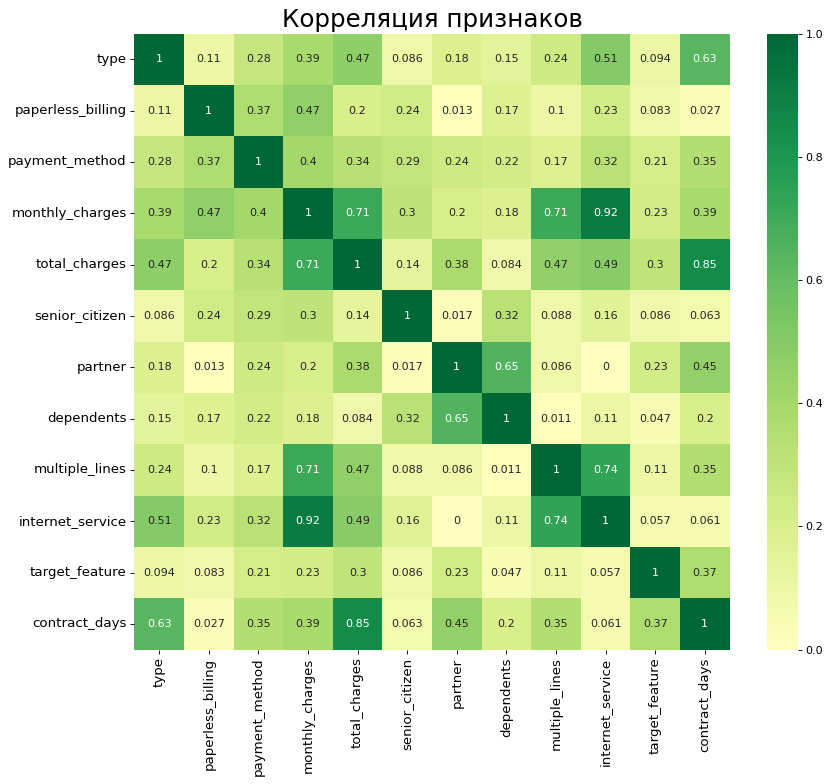

In [186]:
corr_matrix = phik_matrix(df_merged)

# вывод матрицы в виде Heatmap

plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(corr_matrix, xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns, cmap='RdYlGn', center=0, annot=True)

plt.title('Корреляция признаков', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Вопросы
- Надо ли удалять столбец internet_service так как он сильно корелирует со столбцом total_charges?
- Кореляцию выше кого числа стоит удалять (0.60, 0.70, 0.80, 0.90)?


Посмотрим на целевой признак на предмет дисбаланса классов

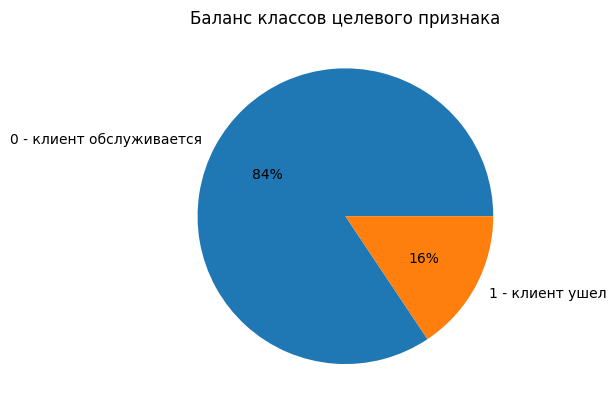

In [187]:
plt.pie(df_merged.target_feature.value_counts(), labels = ['0 - клиент обслуживается', '1 - клиент ушел'], autopct='%1.0f%%')
plt.title('Баланс классов целевого признака')

plt.show()

Дисбаланс классов есть. Это нужно учесть при подготовке данных для машинного обучения. Метрика AUC-ROC не чувствительна к дисбалансу классов, балансировать не нужно.

In [188]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   senior_citizen     7043 non-null   int64  
 6   partner            7043 non-null   object 
 7   dependents         7043 non-null   object 
 8   multiple_lines     7043 non-null   object 
 9   internet_service   7043 non-null   object 
 10  target_feature     7043 non-null   int64  
 11  contract_days      7043 non-null   int64  
dtypes: float64(2), int64(3), object(7)
memory usage: 715.3+ KB


In [189]:
df_merged['target_feature'].value_counts(normalize=True)

0    0.843675
1    0.156325
Name: target_feature, dtype: float64

In [190]:
features = df_merged.drop('target_feature', axis=1)
target = df_merged['target_feature']

In [191]:
# Разобьём на выборки
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            test_size = 0.25,
                                                                            stratify = target,  # добавил
                                                                            random_state = RANDOM_STATE)

print(features_train.shape, target_train.shape)
print(features_test.shape, target_test.shape)

(5282, 11) (5282,)
(1761, 11) (1761,)


In [192]:
target_test

3003    1
5474    0
6537    1
1145    0
81      0
       ..
1549    0
2155    0
2451    1
5200    1
3340    0
Name: target_feature, Length: 1761, dtype: int64

In [193]:
features_train

,type,paperless_billing,payment_method,monthly_charges,total_charges,senior_citizen,partner,dependents,multiple_lines,internet_service,contract_days
2322,Two year,No,Credit card (automatic),20.45,1002.05,0,No,Yes,No,Not_using,1492
6846,Month-to-month,Yes,Mailed check,79.55,238.65,0,No,No,Yes,Fiber optic,92
668,Month-to-month,No,Mailed check,45.65,228.25,0,No,No,No,DSL,153
2081,Month-to-month,Yes,Credit card (automatic),75.30,1749.22,0,Yes,Yes,No,Fiber optic,702
3128,Month-to-month,No,Credit card (automatic),20.35,101.75,0,No,Yes,No,Not_using,153
...,...,...,...,...,...,...,...,...,...,...,...
3869,One year,Yes,Electronic check,98.25,5354.62,0,Yes,No,Yes,Fiber optic,1523
5095,One year,No,Bank transfer (automatic),45.05,2477.75,0,No,No,No,DSL,1676
4455,Month-to-month,Yes,Mailed check,50.45,100.90,0,No,No,No,DSL,62
2798,Month-to-month,Yes,Electronic check,94.90,1328.60,0,No,No,No,Fiber optic,427


In [194]:
# Разделим признаки на числовые и категориальные
numeric = ['monthly_charges', 'total_charges', 'contract_days']
categorical = [column for column in df_merged.columns if df_merged[column].dtype == 'object' and column != 'target_feature']

data_transformer = ColumnTransformer(
                        transformers=[
                            ('scaler', StandardScaler(), numeric),
                            ('ohe', OneHotEncoder(sparse=False, drop='first'), categorical)],
                                remainder="passthrough")

data_transformer.fit(features_train)
features_train_ohe = data_transformer.transform(features_train)
features_test_ohe = data_transformer.transform(features_test)

display(features_train.head())
display(features_test.head())

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,type,paperless_billing,payment_method,monthly_charges,total_charges,senior_citizen,partner,dependents,multiple_lines,internet_service,contract_days
2322,Two year,No,Credit card (automatic),20.45,1002.05,0,No,Yes,No,Not_using,1492
6846,Month-to-month,Yes,Mailed check,79.55,238.65,0,No,No,Yes,Fiber optic,92
668,Month-to-month,No,Mailed check,45.65,228.25,0,No,No,No,DSL,153
2081,Month-to-month,Yes,Credit card (automatic),75.30,1749.22,0,Yes,Yes,No,Fiber optic,702
3128,Month-to-month,No,Credit card (automatic),20.35,101.75,0,No,Yes,No,Not_using,153


,type,paperless_billing,payment_method,monthly_charges,total_charges,senior_citizen,partner,dependents,multiple_lines,internet_service,contract_days
3003,Month-to-month,Yes,Electronic check,79.50,992.16,0,No,Yes,Yes,Fiber optic,365
5474,Month-to-month,Yes,Electronic check,84.60,84.60,0,No,No,Yes,Fiber optic,31
6537,One year,No,Credit card (automatic),115.65,3302.96,0,Yes,No,Yes,Fiber optic,853
1145,Month-to-month,Yes,Bank transfer (automatic),75.50,2657.60,0,Yes,No,No,Fiber optic,975
81,Month-to-month,No,Electronic check,50.55,600.53,0,Yes,Yes,Not_using,DSL,337


Вывод: числовые признаки масштабированы, категориальные - кодированы. Данные готовы к обучению моделей.

Постройка и обучение нескольких моделей
Будем оценивать качество обучения на тренировочной выборке с применением кросс-валидации и подбором гиперпараметров для трёх моделей, построенных на разных принципах:

- модели Логистической регрессии - это линейная модель классификации
- модели RandomForestClassifier - это модель классификации на основе деревьев
- модели CatBoostClassifier - это модель классификации на основе деревьев с применением градиентного бустинга

В результате будет выбрана лучшая модель, которая потом будет проверяться на тестовой выборке.

###  Обучение модели LogisticRegression

In [199]:
%%time

model_lr = LogisticRegression(random_state=RANDOM_STATE)

# определение списка и диапазона гиперпараметров для подбора
grid_space = [{
               'class_weight': [{0:1, 1:4}, {0:1, 1:6}, None]
             }]

# подбор параметров с кросс-валидацией
lr_grid = GridSearchCV(model_lr,
                       param_grid=grid_space,
                       cv=5,
                       scoring='roc_auc',
                       n_jobs=-1)

model_grid_lr = lr_grid.fit(features_train_ohe,target_train)

final_score_lr = model_grid_lr.best_score_

print('Гиперпараметры лучшей модели: '+str(model_grid_lr.best_params_))
print('Метрика ROC-AUC лучшей модели: '+str(final_score_lr))

Гиперпараметры лучшей модели: {'class_weight': {0: 1, 1: 4}}
Метрика ROC-AUC лучшей модели: 0.764461618285573
CPU times: user 122 ms, sys: 85.6 ms, total: 208 ms
Wall time: 847 ms


In [200]:
%%time

model_forest = RandomForestClassifier(random_state=RANDOM_STATE)

# определение списка и диапазона гиперпараметров для подбора
grid_space = [{
                'max_leaf_nodes': [100,150,200],
                'n_estimators': [250, 300, 350, 400, 450],
                'max_depth': [6, 10, 20]
               }]

# подбор параметров с кросс-валидацией
forest_grid = GridSearchCV(model_forest,
                               param_grid=grid_space,
                               cv=5,
                               scoring='roc_auc',
                               n_jobs=-1)

model_grid_forest = forest_grid.fit(features_train_ohe,target_train)

final_score_forest = model_grid_forest.best_score_


print('Гиперпараметры лучшей модели: '+str(model_grid_forest.best_params_))
print('Метрика ROC-AUC лучшей модели: '+str(final_score_forest))

Гиперпараметры лучшей модели: {'max_depth': 10, 'max_leaf_nodes': 100, 'n_estimators': 450}
Метрика ROC-AUC лучшей модели: 0.8246301064495544
CPU times: user 6.35 s, sys: 793 ms, total: 7.14 s
Wall time: 5min 20s


In [201]:
%%time

model_catboost = CatBoostClassifier(random_state=RANDOM_STATE)

# определение списка и диапазона гиперпараметров для подбора
grid_space = [{'depth'         : [4,5,6],
               'learning_rate' : [0.1,0.13,0.15],
               'iterations'    : [400, 500, 600]
               }]

# подбор параметров с кросс-валидацией
cat_boost_grid = GridSearchCV(model_catboost,
                               param_grid=grid_space,
                               cv=5,
                               scoring='roc_auc',
                               n_jobs=-1)

model_grid_catboost = cat_boost_grid.fit(features_train_ohe,target_train)

final_score_catboost = model_grid_catboost.best_score_

print('Гиперпараметры лучшей модели: '+str(model_grid_catboost.best_params_))
print('Метрика ROC-AUC лучшей модели: '+str(final_score_catboost))

0:	learn: 0.5996430	total: 2.63ms	remaining: 1.58s
1:	learn: 0.5281749	total: 5.56ms	remaining: 1.66s
2:	learn: 0.4861783	total: 7.82ms	remaining: 1.56s
3:	learn: 0.4451827	total: 10.4ms	remaining: 1.55s
4:	learn: 0.4174455	total: 12.6ms	remaining: 1.5s
5:	learn: 0.4002150	total: 14.9ms	remaining: 1.47s
6:	learn: 0.3861964	total: 17ms	remaining: 1.44s
7:	learn: 0.3757149	total: 19.4ms	remaining: 1.43s
8:	learn: 0.3642534	total: 21.5ms	remaining: 1.41s
9:	learn: 0.3587094	total: 23.7ms	remaining: 1.4s
10:	learn: 0.3549772	total: 25.8ms	remaining: 1.38s
11:	learn: 0.3498750	total: 28ms	remaining: 1.37s
12:	learn: 0.3453919	total: 30.3ms	remaining: 1.37s
13:	learn: 0.3407295	total: 32.5ms	remaining: 1.36s
14:	learn: 0.3388533	total: 34.8ms	remaining: 1.35s
15:	learn: 0.3359756	total: 36.9ms	remaining: 1.35s
16:	learn: 0.3342372	total: 39.2ms	remaining: 1.34s
17:	learn: 0.3324113	total: 41.4ms	remaining: 1.34s
18:	learn: 0.3308147	total: 43.6ms	remaining: 1.33s
19:	learn: 0.3298057	total: 

### Выбор лучшей модели на основе метрики ROC-AUC

Вывод: На основании обучения разных моделей по результатам оценки по метрике ROC-AUC лучшей моделью с показателем 0.92 выбрана модель CatBoost. Именно ее мы и будем исследовать в дальнейшем.

### Исследование лучшей модели

Проверка качества лучшей модели на тестовой выборке

In [202]:
# Обучение модели CatBoost с лучшими параметрами на всем обучающем наборе
best_cb = CatBoostClassifier(**grid_search_cb.best_params_, random_state=RANDOM_STATE, verbose=0, cat_features=categorical)
best_cb.fit(features_train, target_train)

In [203]:
probabilities_test = model_grid_catboost.predict_proba(features_test_ohe)
probabilities_one_test = probabilities_test[:, 1]

print("Лучшая модель, тестовая выборка, метрика ROC-AUC:")

print(roc_auc_score(target_test, probabilities_one_test))

Лучшая модель, тестовая выборка, метрика ROC-AUC:
0.9332839838492597


In [222]:
y_pred = model_grid_catboost.predict(features_test_ohe)
y_pred_series = pd.Series(y_pred)

accuracy = accuracy_score(target_test, y_pred)
print("Лучшая модель, тестовая выборка, метрика Accuracy:")
print(accuracy)

Лучшая модель, тестовая выборка, метрика Accuracy:
0.9312890403180011


Вывод: Лучшая модель успешно показала уровень метрики ROC-AUC 0.93, что выше заданнного заказчиком порога 0.85.
Также модель показала хороший уровень метрики Accuracy = 0.92

In [223]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(features_test_ohe,target_test) # обучение модели на тренировочной выборке
predictions_dummy = dummy_clf.predict(features_test_ohe) # получение предсказания модели

print("Модель Dummy, тестовая выборка")

# определение качества модели Dummy на тестовой выборке
print("Accuracy:", accuracy_score(target_test, predictions_dummy))

Модель Dummy, тестовая выборка
Accuracy: 0.8438387279954571


Вывод: Лучшая модель показала результат Accuracy 0.92, что выше, чем 0.83 у модели Dummy. Следовательно лучшая модель прошла проверку на адекватность.

### Поcтроение ROC-кривой

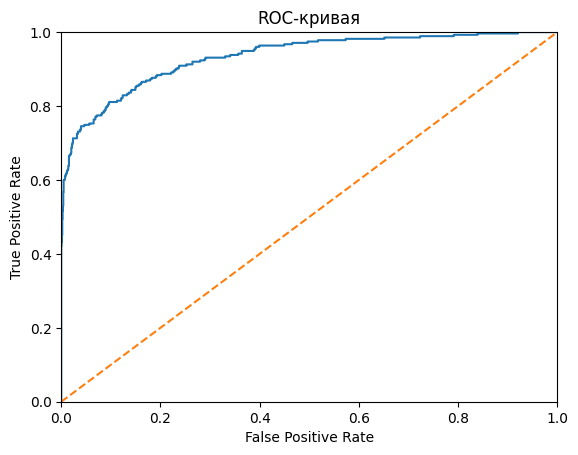

In [224]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Вывод: судя по ROC-кривой, модель дает результат предсказаний высокого качества.

### Construction of the error matrix

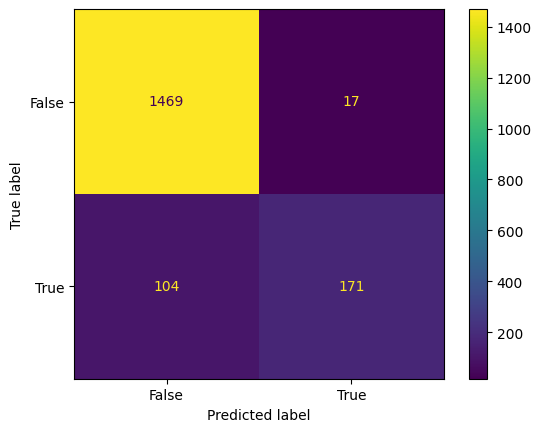

In [225]:
# Предсказание модели
predicted_test = model_grid_catboost.predict(features_test_ohe)

# Преобразование строковых предсказаний в числовые значения
label_encoder = LabelEncoder()
predicted_test_encoded = label_encoder.fit_transform(predicted_test)

# Вычисление confusion matrix
confusion_matrix = metrics.confusion_matrix(target_test, predicted_test_encoded)

# Отображение confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[False, True])
cm_display.plot()
plt.show()

**Вывод:** Матрица ошибок показывает высокое качество предсказания модели.

### Exploring the importance of attributes

In [226]:
feature_importance =  model_grid_catboost.best_estimator_.feature_importances_

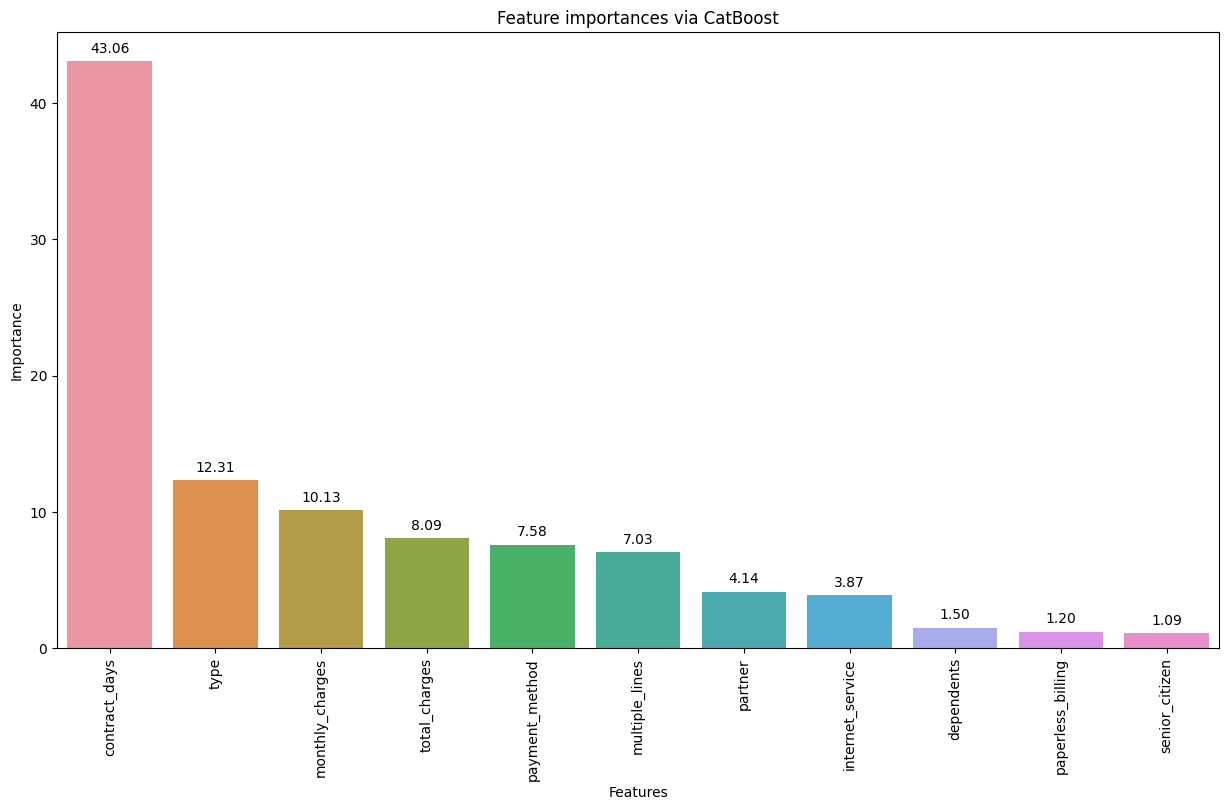

In [227]:
importances = best_cb.get_feature_importance()

features = features_train.columns
importance_dict = {features[i]: importances[i] for i in range(len(features))}
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(15, 8))
bars = sns.barplot(x=[item[0] for item in sorted_importance], y=[item[1] for item in sorted_importance])
plt.title("Feature importances via CatBoost")
plt.ylabel('Importance')
plt.xlabel('Features')
plt.xticks(rotation=90)

for p in bars.patches:
    bars.annotate(format(p.get_height(), '.2f'),
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='center',
                  xytext=(0, 9),
                  textcoords='offset points')

plt.show()

Вывод: Наиболее важными признаками являются 'ContractDays', 'type',  'MonthlyCharges', 'TotalCharges'.

### Общий вывод

**В процессе выполнения проекта было проделано следующее:**

1. Загрузка библиотек и загрузка данных с первичным обзором
2. Предобработка данных
  - заполнение пропусков
  - коррекция типов данных
  - выявление и обработка аномалий
3. Объединение датафреймов
4. Исследование единого датафрейма
  - заполнение пропусков
  - создание новых признаков (при необходимости)
  - создание целевого признака
  - проверка признаков на мультиколлинеарность с использованием phik
5. Разделение данных на учебную и тестовую выборки в пропорции 3:1
6. Кодирование и масштабирование признаков
7. Постройка и обучение на тестовой выборке с подбором гиперпараметров с кросс-валидацией нескольких моделей
  - LogisticRegression
  - RandomForestClassifier
  - CatBoostClassifier
8. Выбор лучшей модели на основе метрики ROC-AUC
9. Исследование лучшей модели
  - проверка качества лучшей модели на тестовой выборке
  - проверка на адекватность
  - построение матрицы ошибок
  - исследование важности признаков лучшей модели.

**Результат обучения моделей:**

- Наилучшее качество по метрике ROC-AUC = 0.92 показала модель градиентного бустинга CatBoostClassifier с подобранными с использованием кросс-валидации гиперпараметрами, следовательно она и признана лучшей.

- Метрика ROC-AUC = 0.93 лучшей модели на тестовой выборке выше целевого уровня 0.85, следовательно модель удвлетворяет требованиям заказчика. Модель также показала высокое качество по метрике Accuracy = 0.92

- Гиперпараметры лучшей модели:
 - 'depth'= 4,
 - 'iterations' = 600,
 - 'learning_rate' = 0.15

- Модель градиентного бустинга CatBoostClassifier прошла проверку на адекватность, показав результат по метрике Accuracy значительно лучше, чем метод DummyClassifier.

**Рекомендация сотрудникам оператора связи «Ниединогоразрыва.ком»:**
- Предлагается использовать разработанную в данном проекте модель на основе градиентного бустинга CatBoostClassifier с подобранными гиперпараметрами для прогнозирования оттока клиентов и, соответственно, оптимального применения промокодов и специальных условий для удержания клиентов.

### Отчёт по решению

В процессе выполнения проекта были выполнены все пункты изначального плана, а именно:
- Загрузка библиотек и загрузка данных с первичным обзором
- Предобработка данных
- Объединение датафреймов
- Исследование единого датафрейма
- Разделение данных на учебную и тестовую выборки
- Кодирование и масштабирование признаков
- Постройка и обучение на тестовой выборке с подбором гиперпараметров с кросс-валидацией нескольких моделей
- Выбор лучшей модели на основе метрики ROC-AUC
- Исследование лучшей модели

Для воспроизводимости результата следует отметить, что по указанию тимлида было выбрано следующее  значение глобальной константы: RANDOM_STATE = 110923

Главной трудностью на этапе обучения моделей являлся низкий показатель метрики ROC-AUC лучшей модели на тестовой выборке: не более 0.80 при целевом уровне 0.85, требуемом заказчиком, при том, что на обучении лучшая модель показывала вполне высокую метрику 0.94. Тимлид изначально инструктировала, что основные потенциальные проблемы скорее всего могут быть вызваны недостаточным качеством обработки признаков. После обращения к тимлиду были получены и выполнены указания по исправлению ошибок при создании нового признака, а также масштабировании и кодировании признаков. В частности, ключевым являлось то ,что  при кодированиии и масштабировании признаков тестовой выборки необходимо было использовать методы, обученные именно на тренировочной выборке, а не на тестовой, как мною делалось изначально. После внесенных исправлений нужный результат был получен: метрика ROC-AUC = 0.93, что существенно выше требуемого заказчиком уровня.

Ключевые шаги в решении задачи:
- Создание, обработка и отбор признаков для обучение моделей
- Обучение моделей и выбор лучшей модели
- Исследование лучшей модели

После анализа изначального набора признаков был исключен ряд признаков с высокой корреляцией между собой. Кроме того был создан новый признак длительности контракта в днях. Для исключения утечки были исключены из датасета признаки с датами. Также был исключен столбец customerID, не являющийся признаком. Был также создан целевой признак на основании даты окончания контракта. В результате иоговый список признаков состоял из следующего набора:
'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines','InternetService', 'ContractDays' (созданный новый признак), 'Churn' (созданный целевой признак).
Данный набор признаков составил разумный баланс между достаточностью информации для качественного обучения моделей с одной стороны и вычислительной нагрузкой, а следовательно и длительностью обучения с другой.

Числовые признаки были масштабированы методом StandardScaler().  
Категориальные признаки были кодированы методом OneHotEncoder().

Было проведено обучение на тренировочной выборке трёх моделей, построенных на разных принципах:

- модель Логистической регрессии - линейная модель классификации
- модель RandomForestClassifier - модель классификации на основе деревьев
- модель CatBoostClassifier - модель классификации на основе деревьев с применением градиентного бустинга

При обучении применялся подбор нескольких гиперпараметров с кросс-валидацией при помощи метода GridSearchCV()  
В результате лучшей была выбрана модель CatBoostClassifier, которая показала уровень метрики ROC-AUC = 0.92 на тренировочной выборке со следующим набором гиперпараметров:
 - 'depth'= 4,
 - 'iterations' = 600,
 - 'learning_rate' = 0.15

На тестовой выборке лучшая модель с данными гиперпараметрами показала уровень метрики ROC-AUC = 0.93 выше целевого уровня 0.85, удовлетворяющего требования заказчика.
Высокое качество модели было подтверждено метрикой Accuracy = 0.92.  

- Cогласно ROC-кривой, модель дает результат предсказаний высокого качества.
- Матрица ошибок также подтверждает высокое качество предсказания модели.
- Была исследована важность признаков лучшей модели и были выявлены самые важные признаки: 'ContractDays', 'MonthlyCharges', 'TotalCharges'

Лучшая модель прошла проверку на адекватность, показав результат по метрике Accuracy значительно лучше, чем метод DummyClassifier.

В результате выполнения проекта сотрудникам оператора связи предлагается использовать разработанную в данном проекте модель на основе градиентного бустинга CatBoostClassifier с подобранными гиперпараметрами для прогнозирования оттока клиентов и, соответственно, оптимального применения промокодов и специальных условий для удержания клиентов.